In [1]:
# importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Target variable

Let's have a look at the distribution for the target variable, 'esi'. 

In [33]:
# loading the dataframe
df = pd.read_parquet('../data/cleaned/dataClean.parquet')

We will save our target variable as 'y'.

In [34]:
# setting our target variable as 'y'
y = df['esi']

Let's look at the distribution of values in y.

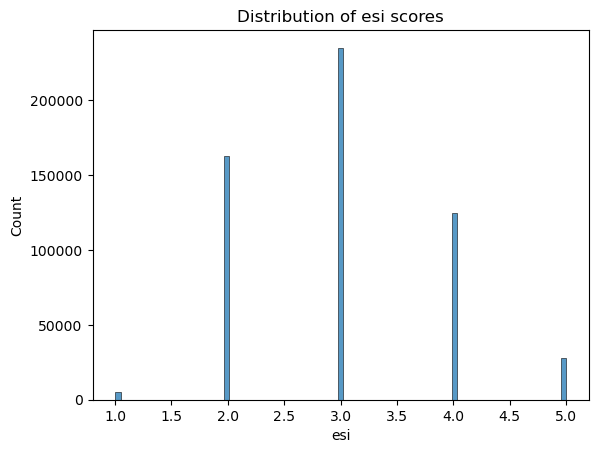

In [35]:
# plotting a histogram for 'esi'
plt.figure()
sns.histplot(y)
plt.title('Distribution of esi scores')
plt.show()

The esi scores seem to be roughly normally distributed, with a minumum value of 1 and maximum of 5. Given the distribution, a model that aims to predict esi score may be good at predicting esi scores of 3, but not so good at predicting scores of 1 or 5. Since we have such a low proportion of data with esi score of 1 or 5, we will adjust our target variable to be a custom measure called 'medical urgency', or MU. We will define this as follows:

$
\begin{equation}
MU = 
\begin{cases}
0, & \text{if esi} \leq 2 \\
1, & \text{if esi} = 3 \\
2, & \text{if esi} \geq 4
\end{cases}
\end{equation}
$

Let's make this new column in the dataframe. We start by defining a function that converts esi to medical urgency.




In [36]:
# defining a function that converts esi score to medical urgency score
def m_u(esi):
    if esi <= 2:
        return(0)
    if esi == 3:
        return(1)
    if esi >= 4:
        return(2)

In [37]:
# applying our function to the 'esi' column
df['medical_urgency'] = df['esi'].apply(m_u)

Let's save the new dataframe.

In [41]:
# saving the dataframe with the new target variable
df.to_parquet('../data/cleaned/dataCleanWMedicalUrgency.parquet')

We will now redefine y to be our new target variable, 'medical_urgency'.

In [39]:
# defining the target variable, y, as 'medical_urgency'
y = df['medical_urgency']

Now let's have a look at the distribution of our target variable using a histogram.

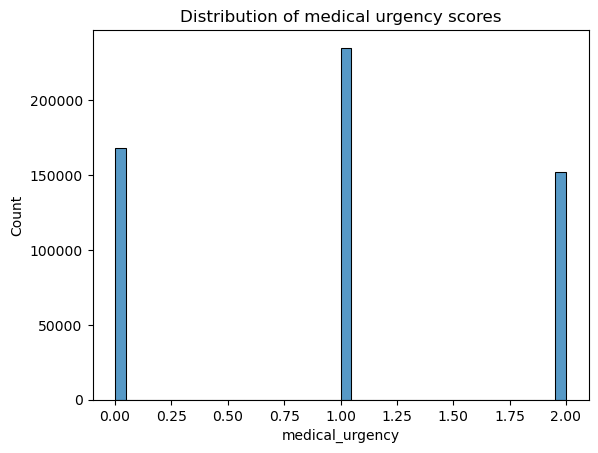

In [40]:
# plotting a histogram for 'medical_urgency'
plt.figure()
sns.histplot(y)
plt.title('Distribution of medical urgency scores')
plt.show()

This looks good! We now have plenty of datapoints for each of our values in the target variable. Lets check its data type.

In [18]:
# getting info about the target variable
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 555417 entries, 0 to 555416
Series name: medical_urgency
Non-Null Count   Dtype
--------------   -----
555417 non-null  int64
dtypes: int64(1)
memory usage: 4.2 MB


The data type is integer, which is as we want! 

# Demographic data

In [28]:
# loading the demographic data
X_dem = pd.read_parquet('../data/cleaned/demdata.parquet')

Now let's take a look at the numerical feature variables.

In [29]:
# getting high level stats from the numerical feature variables,
X_dem.describe()

,age
count,555417.000000
mean,49.884271
std,20.414192
min,18.000000
25%,32.000000
50%,49.000000
75%,64.000000
max,108.000000


Nothing looks too out of the ordinary. There is a max age of 108, which is very high, and we may need to monitor data points close to this, as ages of 108 are unusual, and could skew our results and influence our models. 

The minimum age is 18, so there are no children in the cleaned dataset, so our model will only be trained on adults, and so will only be useful in predicting esi score for adults. 

Now let's look at the distribution for each variable. 

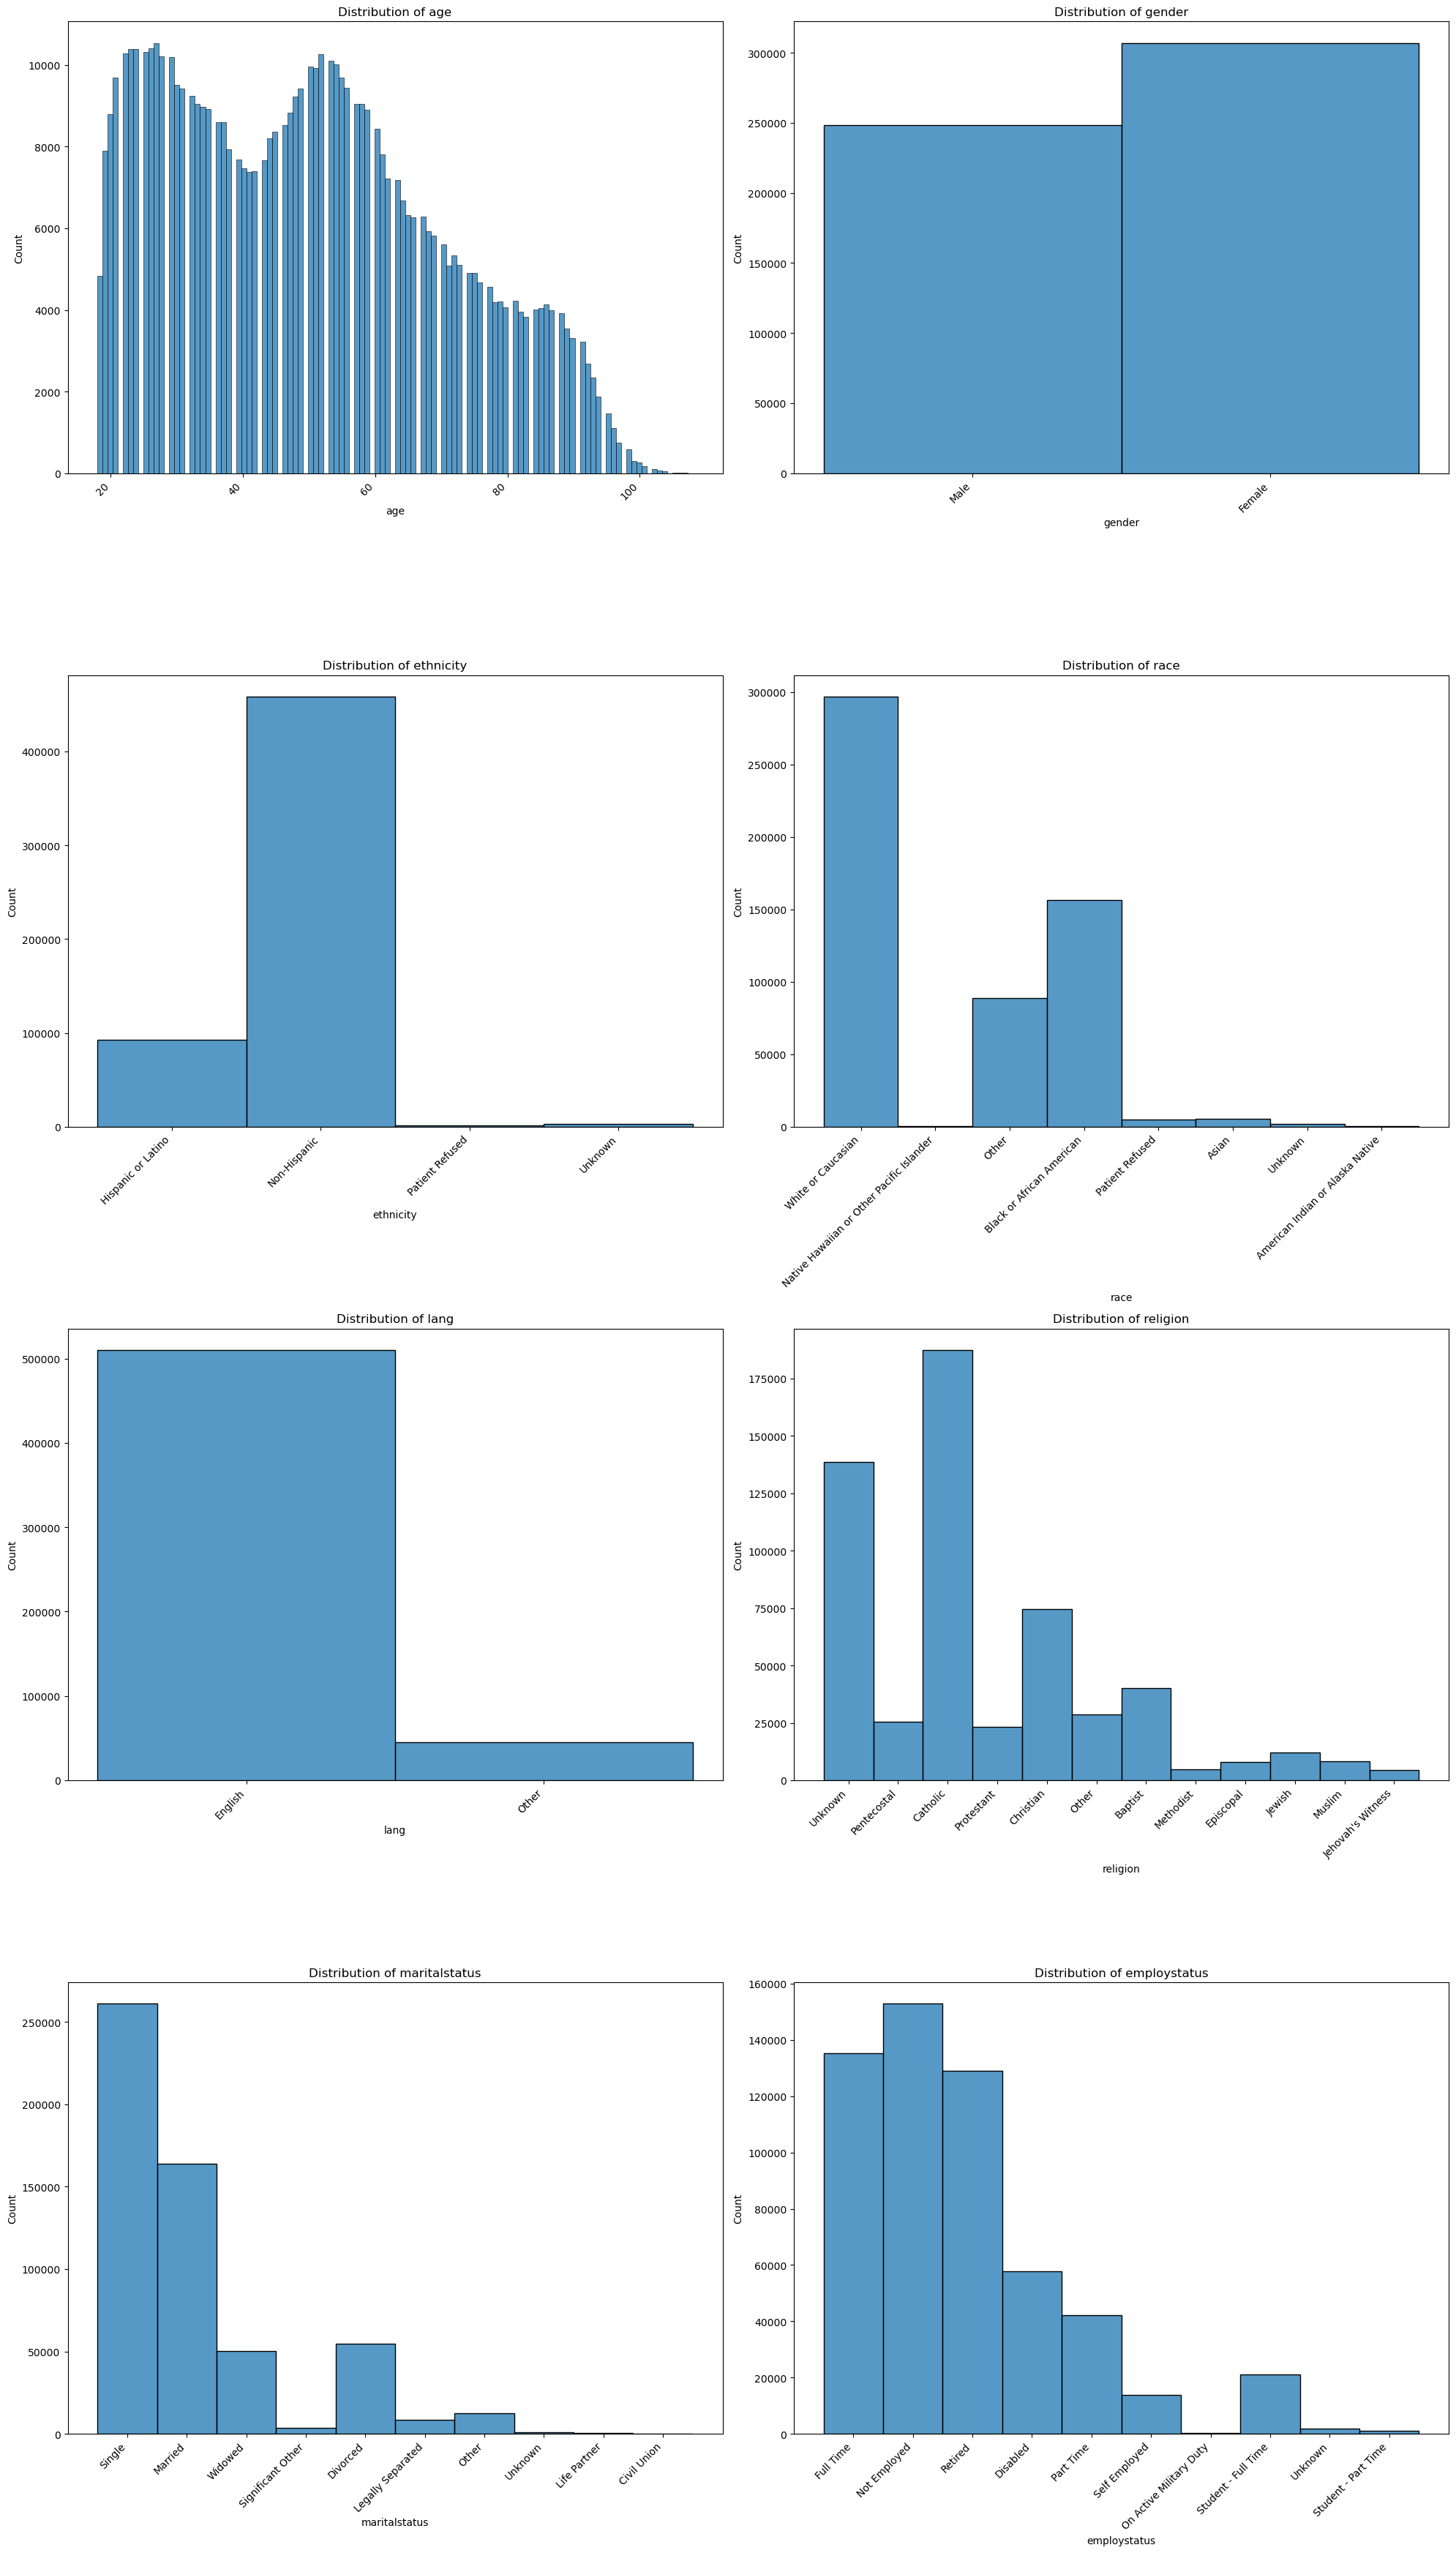

In [30]:
# greating a plot to show histograms of the distribution of each variable
plt.subplots(4,2,figsize=(20,35))

for i, col in enumerate(X_dem.columns):
    plt.subplot(4, 2, i + 1)
    sns.histplot(X_dem[col])
    plt.ticklabel_format
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()

Age:

There seems to be multiple distributions contributing to the overall age distribution. Each peak could indicate a distribution of a certain age range: the peak at around 90 years old could represent the mean of a group of people in the 'old age' range (say 70 - 110) that go to the emergency department (ED), which may follow a skewed normal distribution; the distribution with a peak at around 55 years old could be of the group of 'middle aged' people going to the emergency department, and the distribution with a peak at around 25 could be of the group of 'young people' visitng the emergency department. 

The fact that there are more people of middle age going to the emergency department than of old age could be explained by the fact that there are more people of middle age in the US than of old age. The fact that there seem to be roughly as many young people going to the emergency department as of middle age is a little harder to explain, since we might expect that younger people have few reasons to go to the emergency department. However, it may be that young people go for different reasons to people of middle age, and so the actualy number from each group going to the ED may not be directly comparable. 

Gender: 

We see a roughly equal split between male and female and is representative of the population of the US (https://www.statista.com/statistics/737923/us-population-by-gender/#:~:text=Projection%20estimates%20calculated%20using%20the,US%20Census%20data%20for%202021.), which is good since it is the population of the US that we wish to make predictions about. 

Ethnicity:

We have about 20% hispanic or latino and most of the remainder of patients were non-hispanic. This is representative of the US population as a whole (https://www.pewresearch.org/short-reads/2023/09/05/who-is-hispanic/#:~:text=The%20Census%20Bureau%20estimates%20there,19%25%20of%20the%20nation's%20population.), which is good, though it would be nice to know the distribution of ethnicities within the non-hispanic category.

Race:

Around 55% of patients were white, which is slightly less than the percentage of the US population that is white (around 75% - https://en.wikipedia.org/wiki/White_Americans#:~:text=As%20of%20July%201%2C%202022,were%2059.3%25%20of%20the%20population.). Around 30% of the patients were black african american, which is roughly double the percentage of the US population that is black (https://www.census.gov/quickfacts/fact/table/US/PST045222). 

Language:

Almost all rows have english in the laguage column. The Hospital is in the US and so this is unsurprising. 

Religion:

A significant porportion of our data has unknown in the religion column, meaning we may have to drop it as a feature variable. We will investigate its effect on the target, but do not expect it to have any impact on esi score, in whcih case it will not be an issue to drop it anyway. 

It is worth mentioning here that our model will (theoretically) e used to assign an esi score to a patient which then determines how urgently they need help. We would hope that factors such as race, language and religion have not effect on esi score, but even if we find that they did, we should really exclude these factors anyway, as we would not want to bias esi scores so that one particular race or religion is prioritised for care. 

Marital status:

Here we have a varied distribution, which roughly follows the marital status distribution of people in the US population (https://www.census.gov/newsroom/stories/unmarried-single-americans-week.html#:~:text=From%20nationalsinglesday.us%2C%20%E2%80%9CDid,those%20who%20have%20never%20married.). 

Employment status:

We have a good amoount of data points from a wide range of employement statuses. 

Let's check the data types for each feature variable.

In [26]:
X_dem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555417 entries, 0 to 555416
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   age            555417 non-null  float64
 1   gender         555417 non-null  object 
 2   ethnicity      555417 non-null  object 
 3   race           555417 non-null  object 
 4   lang           555417 non-null  object 
 5   religion       555417 non-null  object 
 6   maritalstatus  555417 non-null  object 
 7   employstatus   555417 non-null  object 
dtypes: float64(1), object(7)
memory usage: 33.9+ MB


Only one of our feature variables here is numeric. We will have to make the other columns numeric in the preprocessing stage.